[Dmaziuk's page](https://github.com/dmaziuk/diy-zhl/blob/master/diyzhl.ipynb)

[Introductory Deco Lessons](https://www.shearwater.com/wp-content/uploads/2012/08/Introductory-Deco-Lessons.pdf)

[Understanding M-values](https://www.frogkick.nl/files/understanding_m-values.pdf)

[DIY deco](http://www.lizardland.co.uk/DIYDeco.html)

# Schreiner Equation
## Fundamental equation of the dissolved gas

$\frac{dP}{dt} = k(P_i - P)$

For ascent or descent at a constant rate, this resolves:

$P = P_{i,0}+R\left(t-\frac{1}{k}\right)-\left[P_{i,0}-P_0-\frac{R}{k}\right]e^{-kt}$
- $P$ Final compartment inert gas pressure
- $P_{i,0}$ Initial ambient pressure
- $P_0$ Initial compartment inert gas pressure
- $R$ rate of change in inspired gas pressure with change in ambient pressure
- $t$ time
- $k$ $\frac{ln(2)}{\lambda}$
- $\lambda$: half time

+-------------+-------------+--------+--------+-------------+--------+--------+
| compartment | n2_halflife |  n2_a  |  n2_b  | he_halflife |  he_a  |  he_b  |
+-------------+-------------+--------+--------+-------------+--------+--------+
|     1.0     |     5.0     | 1.1696 | 0.5578 |     1.88    | 1.6189 | 0.477  |
|     2.0     |     8.0     |  1.0   | 0.6514 |     3.02    | 1.383  | 0.5747 |
|     3.0     |     12.5    | 0.8618 | 0.7222 |     4.72    | 1.1919 | 0.6527 |
|     4.0     |     18.5    | 0.7562 | 0.7825 |     6.99    | 1.0458 | 0.7223 |
|     5.0     |     27.0    |  0.62  | 0.8126 |    10.21    | 0.922  | 0.7582 |
|     6.0     |     38.3    | 0.5043 | 0.8434 |    14.48    | 0.8205 | 0.7957 |
|     7.0     |     54.3    | 0.441  | 0.8693 |    20.53    | 0.7305 | 0.8279 |
|     8.0     |     77.0    |  0.4   | 0.891  |    29.11    | 0.6502 | 0.8553 |
|     9.0     |    109.0    | 0.375  | 0.9092 |     41.2    | 0.595  | 0.8757 |
|     10.0    |    146.0    |  0.35  | 0

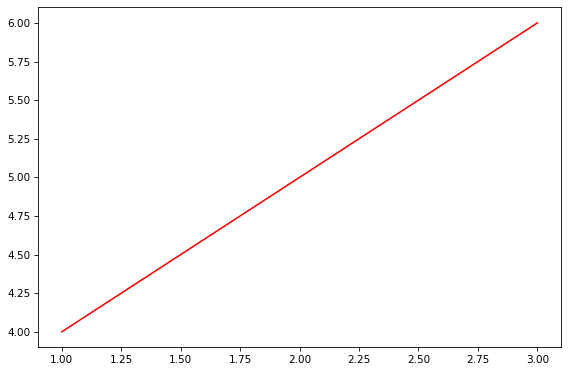

In [24]:
import numpy as np
import pandas as pd
import math
from prettytable import PrettyTable

df = pd.DataFrame([
    [1,    5.0, 1.1696, 0.5578,   1.88, 1.6189, 0.4770],
    [2,    8.0, 1.0000, 0.6514,   3.02, 1.3830, 0.5747],
    [3,   12.5, 0.8618, 0.7222,   4.72, 1.1919, 0.6527],
    [4,   18.5, 0.7562, 0.7825,   6.99, 1.0458, 0.7223],
    [5,   27.0, 0.6200, 0.8126,  10.21, 0.9220, 0.7582],
    [6,   38.3, 0.5043, 0.8434,  14.48, 0.8205, 0.7957],
    [7,   54.3, 0.4410, 0.8693,  20.53, 0.7305, 0.8279],
    [8,   77.0, 0.4000, 0.8910,  29.11, 0.6502, 0.8553],
    [9,  109.0, 0.3750, 0.9092,  41.20, 0.5950, 0.8757],
    [10, 146.0, 0.3500, 0.9222,  55.19, 0.5545, 0.8903],
    [11, 187.0, 0.3295, 0.9319,  70.69, 0.5333, 0.8997],
    [12, 239.0, 0.3065, 0.9403,  90.34, 0.5189, 0.9073],
    [13, 305.0, 0.2835, 0.9477, 115.29, 0.5181, 0.9122],
    [14, 390.0, 0.2610, 0.9544, 147.42, 0.5176, 0.9171],
    [15, 498.0, 0.2480, 0.9602, 188.24, 0.5172, 0.9217],
    [16, 635.0, 0.2327, 0.9653, 240.03, 0.5119, 0.9267],
    ],
    columns = ['compartment',
               'n2_halflife', 'n2_a', 'n2_b',
               'he_halflife', 'he_a', 'he_b']
)
def generate_ascii_table(df):
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    print(x)
    return x

generate_ascii_table(df)

# in bar
SURFACE_PRESSURE = 1
WATER_VAPOR_PRESSURE_ALVEOLI = 0.0567

# in fsw
# SURFACE_PRESSURE = 33
# WATER_VAPOR_PRESSURE_ALVEOLI = 2.042

# 1st dive so 0.79 N2 and 0 HE
surface_n2_pp = 0.79

class Gas(object):
    def __init__(self, n2_pc, he_pc):
        if not 0 <= n2_pc <= 1:
            raise RuntimeError("N2 must be between 0 and 1")
        if not 0 <= he_pc <= 1:
            raise RuntimeError("He must be between 0 and 1")
        if not 0 <= n2_pc + he_pc <= 1:
            raise RuntimeError("He+N2 must be between 0 and 1")

        self.n2_pc = n2_pc
        self.he_pc = he_pc
        self.o2_pc = 1.0 - he_pc - n2_pc

descent_rate = 20 # 20m / min
ascent_rate = 9 # 9m / min
gas = Gas(n2_pc=0.4, he_pc=0.45)

class Tissues(object):
    def __init__(self, n2_p=None, he_p=None):
        # default tissues saturation for surface
        # Compute P0(He) and P0(N2)
        if n2_p is not None:
            self.n2_p = n2_p
        else:
            self.n2_p = pd.array([(SURFACE_PRESSURE-WATER_VAPOR_PRESSURE_ALVEOLI) * surface_n2_pp] * 16)

        if he_p is not None:
            self.he_p = he_p
        else:
            self.he_p = pd.array([0] * 16)

def get_partial_pressures(
        tissues,  # tissue loading vectors for compartments
        gas,  # gas composition
        start_pressure,  # in bar
        end_pressure,  # in bar
        t,  # time for depth change
):
    """

    :type tissues: Tissues
    :type gas: Gas
    """
    if t:
        rate_depth = (end_pressure - start_pressure) / t
    else:
        rate_depth = 0

    # Compute P_{i,0}(He)
    init_inspired_pp_he = (start_pressure - WATER_VAPOR_PRESSURE_ALVEOLI) * gas.he_pc
    init_inspired_pp_n2 = (start_pressure - WATER_VAPOR_PRESSURE_ALVEOLI) * gas.n2_pc

    rate_change_he_p = rate_depth * gas.he_pc
    rate_change_n2_p = rate_depth * gas.n2_pc

    # Compute k(He)
    kHe = math.log(2) / df['he_halflife']

    # P(He) = Pi,0(He) + R(HE) (t - 1/k(He)) - (Pi,0(He) - P0(He) - R(He)/k(He)) exp(-2 k(He))
    p_he = init_inspired_pp_he + rate_change_he_p * (t - 1 / kHe) \
           - (init_inspired_pp_he - tissues.he_p - rate_change_he_p / kHe) \
           * np.exp(-kHe * t)

    kN2 = math.log(2) / df['n2_halflife']
    p_n2 = init_inspired_pp_n2 + rate_change_n2_p * (t - 1 / kN2) \
           - (init_inspired_pp_n2 - tissues.n2_p - rate_change_n2_p / kN2) \
           * np.exp(-kN2 * t)

    return Tissues(n2_p=p_n2, he_p=p_he)

def ceiling(
        tissues: Tissues) -> float:
    a = (df['n2_a'] * tissues.n2_p + df['he_a'] * tissues.he_p) / (tissues.n2_p + tissues.he_p)
    b = (df['n2_b'] * tissues.n2_p + df['he_b'] * tissues.he_p) / (tissues.n2_p + tissues.he_p)
    tissue_ceilings = ((tissues.n2_p + tissues.he_p) - a) * b
    return max(tissue_ceilings)

def depth_to_pressure(depth):
    return depth / 10.0 + 1.0

def pressure_to_depth(pressure):
    return (pressure - 1.0) * 10.0

dive = [
    (0, 0),
    (40, 1),    # 40 meters at 2 mins
    (40, 21),   # 40 meters at 22 mins
]
tissues = Tissues()
print("initial ceiling: {}".format(pressure_to_depth(ceiling(tissues))))

i_step = 0
((start_depth, start_time), (end_depth, end_time)) = list(zip(dive[:-1], dive[1:]))[i_step]
tissues = get_partial_pressures(
        tissues,        # vector for compartments
        gas,
        depth_to_pressure(start_depth),    # for example 0 feet
        depth_to_pressure(end_depth),      # for example 120 feet
        end_time-start_time,              # time for depth change
)
print("N2tissues: {}".format(tissues.n2_p))
print("ceiling: {}".format(pressure_to_depth(ceiling(tissues))))
    # tissues = get_partial_pressures(
    #         tissues,  # vector for compartments
    #         gas,
    #         end_depth,    # for example 0 feet
    #         end_depth,      # for example 120 feet
    #         20,              # time for depth change
    # )
    # print("ceiling: {}".format(ceiling(tissues)))


i_step = 1
((start_depth, start_time), (end_depth, end_time)) = list(zip(dive[:-1], dive[1:]))[i_step]
tissues = get_partial_pressures(
        tissues,        # vector for compartments
        gas,
        depth_to_pressure(start_depth),    # for example 0 feet
        depth_to_pressure(end_depth),      # for example 120 feet
        end_time-start_time,              # time for depth change
)
print("N2tissues: {}".format(tissues.n2_p))
print("ceiling: {}".format(pressure_to_depth(ceiling(tissues))))
    # tissues = get_partial_pressures(
    #         tissues,  # vector for compartments
    #         gas,
    #         end_depth,    # for example 0 feet
    #         end_depth,      # for example 120 feet
    #         20,              # time for depth change
    # )
    # print("ceiling: {}".format(ceiling(tissues)))

%matplotlib inline
from matplotlib import pyplot as plt
t = np.linspace(0, 2*math.pi, 800)
a = np.sin(t)
plt.figure(figsize=(9, 6), dpi=75)
plt.plot([1, 2, 3], [4, 5, 6], 'r')
plt.show()
